# Imports

In [14]:
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sb
from pathlib import Path
import matplotlib.pyplot as plt
from xml.etree import ElementTree

# Parsers
## XML Parser for NPSCHATCORPUS
Custom build XML parser, created for loading the NPSCHATCORPUS.

In [15]:
#Initial Dataframe
df_NPS = pd.DataFrame(columns = ["Text", "Label"])
#XML Parser for NPSCHAT CORPUS
folder_path = "../npsChat/XML Files"
XML_files = os.listdir(folder_path)
for f in XML_files:
    file_name = "../npsChat/XML Files/" + f
    Tree = ElementTree.parse(file_name)
    session = Tree.getroot()
    for Posts in session:
        for post in Posts:
            Utt_Class = (post.attrib["class"])
            Utt_text = post.text
            new_Row = {"Text": Utt_text, "Label": Utt_Class}
            df_NPS = df_NPS.append(new_Row, ignore_index = True)

df_NPS

,Text,Label
0,now im left with this gay name,Statement
1,:P,Emotion
2,PART,System
3,hey everyone,Greet
4,ah well,Accept
...,...,...
10565,hi 11-09-teensUser3,Greet
10566,JOIN,System
10567,"Hi, 11-09-teensUser197.",Greet
10568,"Not that I know of, 11-09-teensUser98",nAnswer


In [16]:
df_NPS = df_NPS[df_NPS['Label'] != 'System']
df_NPS

,Text,Label
0,now im left with this gay name,Statement
1,:P,Emotion
3,hey everyone,Greet
4,ah well,Accept
6,10-19-20sUser7 is a gay name.,Accept
...,...,...
10564,Were you on one of the nicks i kicked out 11-0...,ynQuestion
10565,hi 11-09-teensUser3,Greet
10567,"Hi, 11-09-teensUser197.",Greet
10568,"Not that I know of, 11-09-teensUser98",nAnswer


In [17]:
NPS_distribution = df_NPS.groupby(df_NPS['Label']).count()['Text']
NPS_labels = df_NPS['Label'].unique().tolist()
NPS_labels.sort()
NPS_sorted = NPS_distribution.sort_values(ascending=False)

## CSV "Parser" for ConvitKit Annotated Corpus

<AxesSubplot:xlabel='Label'>

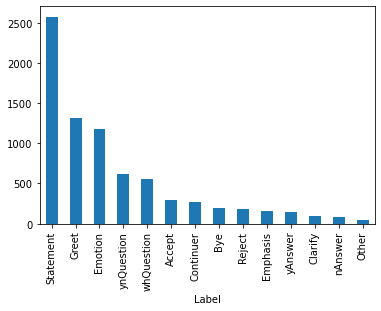

In [18]:
NPS_sorted.plot(kind='bar')

In [19]:
#Rob van der Goot, Ahmet ̈Ust ̈un, Alan Ramponi, andBarbara Plank. 2020a. MaChAmp proportional sam-pling. https://github.com/machamp-nlp/machamp/blob/master/machamp/modules/bucket_batch_sampler.py

def sample_smoothing(dataframe, sampling_smoothing):

    distribution = dataframe.groupby(dataframe['Label']).count()['Text']
    labels = dataframe['Label'].unique().tolist()
    labels.sort()
    # sampling_smoothing: float = 1.0

    if sampling_smoothing != 1.0:
        all_batches = []
        df_sorted = dataframe.sort_values(by='Label')

        for label in labels:
            df_Batch = df_sorted[df_sorted['Label'] == label]
            batch = df_Batch.values.tolist()
            all_batches.append(batch)


        sizes = distribution.tolist()
        total_size = sum(sizes)

        # calculate new size based on smoothing
        new_sizes = []
        total_new_prob = 0.0
        for size in sizes:
            pi = size/total_size
            total_new_prob += math.pow(pi, sampling_smoothing)

        for size in sizes:
            pi = size/total_size
            prob = (1/pi) * (math.pow(pi, sampling_smoothing)/total_new_prob)
            new_sizes.append(int(size * prob))
        # print(new_sizes)

        # collect all batches
        this_epoch_all_batches = []
        for dataset_idx in range(len(sizes)):
            new_size = new_sizes[dataset_idx]
            #random.shuffle(all_batches[dataset_idx])
            while new_size > len(all_batches[dataset_idx]):
                all_batches[dataset_idx] += all_batches[dataset_idx]
            this_epoch_all_batches += all_batches[dataset_idx][:new_size]

        # shuffle all batches
        random.seed(1)
        random.shuffle(this_epoch_all_batches)
        # recreate dataframe
        return pd.DataFrame(this_epoch_all_batches, columns=['Text', 'Label'])

    else: 
        return dataframe

In [20]:
df1 = sample_smoothing(df_NPS, 1.0)
df75 = sample_smoothing(df_NPS, 0.75)
df50 = sample_smoothing(df_NPS, 0.50)
df25 = sample_smoothing(df_NPS, 0.25)
df0 = sample_smoothing(df_NPS, 0.0)

In [21]:
df1_distribution = df1.groupby(df1['Label']).count()['Text']
df75_distribution = df75.groupby(df75['Label']).count()['Text']
df50_distribution = df50.groupby(df50['Label']).count()['Text']
df25_distribution = df25.groupby(df25['Label']).count()['Text']
df0_distribution = df0.groupby(df0['Label']).count()['Text']
# print(df75_distribution)
# print(df50_distribution)
# print(df25_distribution)
# print(df0_distribution)

In [22]:
df1_sorted = df1_distribution.sort_values(ascending=False)
df75_sorted = df75_distribution.sort_values(ascending=False)
df50_sorted = df50_distribution.sort_values(ascending=False)
df25_sorted = df25_distribution.sort_values(ascending=False)
df0_sorted = df0_distribution.sort_values(ascending=False)

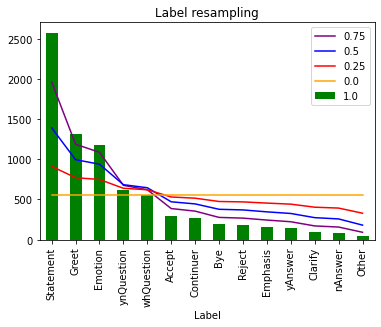

In [23]:
fix, ax = plt.subplots()
x_labels = NPS_sorted.index.tolist()
df1_sorted.plot(kind='bar', color='green', label = 1.0)
df75_sorted.plot(kind='line', color='purple', label = 0.75 )
df50_sorted.plot(kind='line', color='blue', label = 0.50)
df25_sorted.plot(kind='line', color='red', label = 0.25)
df0_sorted.plot(kind='line', color='orange', label = 0.0)
ax.legend()
plt.xticks(np.arange(14), x_labels, rotation = 90)
plt.title('Label resampling')
plt.show()